In [1]:
import numpy as np
import scipy as sp
import pymongo
import pandas as pd
import nsepy
import datetime as dt
import matplotlib.pyplot as plt
import urllib.request, json
import os
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import date
from datetime import timedelta
from pymongo import MongoClient
from nsepy import get_history

#print((dir(tf.feature_column)))
print(tf.__version__)

client=MongoClient("mongodb://localhost:27018/",username="stockadm",password="1qaz@WSX")
db=client["stockWarehouse"]
equityList=db["stocklist"]
stockWarehouse=db["stockWarehouse"]

2.0.0


In [2]:
def getIndustryPctChange(stockName,startDate,endDate,client):
    
    db=client["stockWarehouse"]
    equityList=db["stocklist"]
    stockWarehouse=db["stockWarehouse"]
    finaldf=pd.DataFrame(stockWarehouse.find({'Symbol':stockName,'Date':{'$gt':startDate},'Date':{'$lt':endDate}},{'_id':0,'Date':1,'Close':1}))
    finaldf['Date']=finaldf['Date'].astype('datetime64[ns]')
    finaldf.set_index('Date',inplace=True)
    finaldf.sort_index(inplace=True)
    for i in equityList.find({'Issuer Name':stockName,'Security Name':{'$ne':'Inactive'},'State':"A"},{"ISIN No":1,"_id":0}):
        industryName=i['ISIN No']
        
    print(industryName,startDate,endDate)
    
    for i in equityList.find({'Issuer Name':{'$ne':stockName},"ISIN No":industryName,'Security Name':{'$ne':'Inactive'},'State':"A"},{'Issuer Name':1,"_id":0}):
         
         tmpdf=pd.DataFrame(stockWarehouse.find({'Symbol':i['Issuer Name'],'Date':{'$gt':startDate},'Date':{'$lt':endDate}},{'_id':0,'Date':1,'Close':1}))
         tmpdf['Date']=tmpdf['Date'].astype('datetime64[ns]') 
         tmpdf.set_index('Date',inplace=True)
         tmpdf.sort_index(inplace=True)   
         finaldf=finaldf.join(tmpdf,rsuffix=i['Issuer Name'],on='Date')
         finaldf.fillna(0)
    
    finaldf.dropna(inplace=True)
    finaldf['Close_ind']=0
    for i in finaldf.itertuples():
        cnt=0
        vsum=0
        for j in i:
            if cnt==0 :
                idx=j
                cnt=cnt+1
            else: 
                if j != 0:
                    vsum=vsum+j
                    cnt=cnt+1
        finaldf.loc[idx,'Close_ind']=vsum/cnt
    #print(finaldf['Close_ind'].head(5))    
    return finaldf['Close_ind']        
            

In [3]:
stockName='SBIN'
industryName=0
startDate=0
endDate=0
# for i1 in stockWarehouse.find():
for i1 in stockWarehouse.find({'Symbol':stockName},{'_id':0,'Date':1}).sort('Date',1).limit(1):
    startDate=i1['Date']    
for i2 in stockWarehouse.find({'Symbol':stockName},{'_id':0,'Date':1}).sort('Date',-1).limit(1):
    endDate=i2['Date']    

industrydf=pd.DataFrame(getIndustryPctChange(stockName,startDate,endDate,client))

niftydf=pd.DataFrame(get_history(symbol="NIFTY",start=startDate,end=endDate,index=True))
niftydf.index=niftydf.index.astype('datetime64[ns]')
niftydf.sort_index(inplace=True)

stockdf=pd.DataFrame(stockWarehouse.find({'Symbol':stockName},{'_id':0,'Date':1,'Close':1}))
stockdf['Date']=stockdf['Date'].astype('datetime64[ns]')
stockdf.set_index('Date',inplace=True)
stockdf.sort_index(inplace=True)

#print(stockdf['Close'].head(5))
#print()
#print(niftydf['Close'].head(5))
#print()
#print(industrydf['Close_ind'].head(5))

inputdf=pd.DataFrame(stockdf['Close'])
inputdf=inputdf.join(industrydf,on='Date')
inputdf=inputdf.join(niftydf['Close'],on='Date',rsuffix="_nifty")
inputdf['Close_pct']=inputdf['Close'].pct_change(1)
inputdf['Close_ind_pct']=inputdf['Close_ind'].pct_change(1)
inputdf.dropna(inplace=True)

#print(inputdf.tail(10))
#print(inputdf.head(10))
print(inputdf.head(5))
print(inputdf.size)

Banks 2014-09-04 00:00:00 2020-04-15 00:00:00
              Close   Close_ind  Close_nifty  Close_pct  Close_ind_pct
Date                                                                  
2014-09-05  2515.75  372.482857      8086.85   0.011906      -0.000077
2014-09-08  2565.90  376.590000      8173.90   0.019934       0.011026
2014-09-09  2567.35  376.787143      8152.95   0.000565       0.000523
2014-09-10  2549.95  376.437143      8094.10  -0.006777      -0.000929
2014-09-11  2603.10  381.417143      8085.70   0.020844       0.013229
6625


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


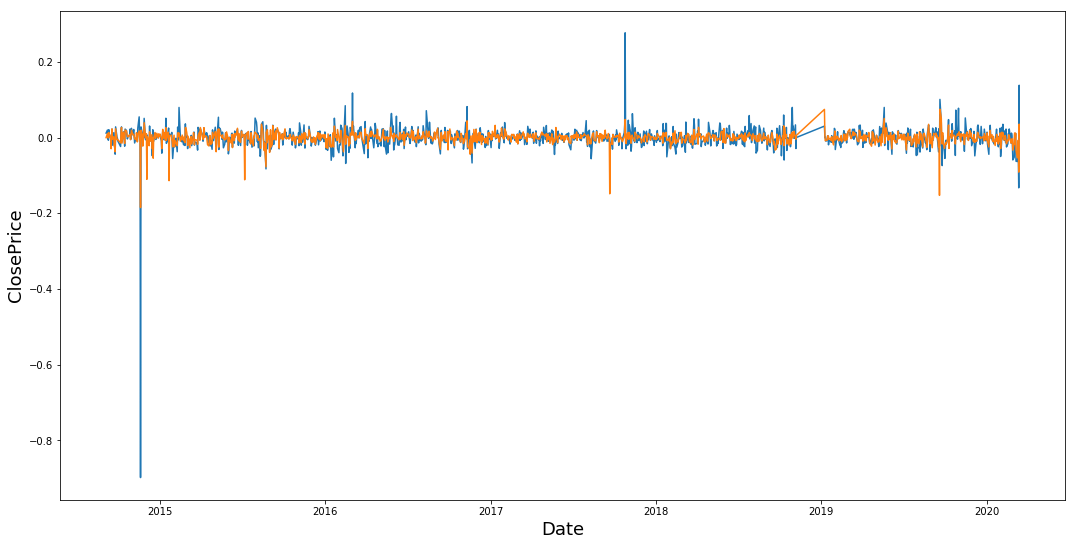

6625


In [4]:
plt.figure(figsize = (18,9))
#print(inputdf['Close'].head(100))
plt.plot((inputdf.index),(inputdf['Close_pct']))
#plt.plot((inputdf.index),(inputdf['Close_nifty']))
plt.plot((inputdf.index),(inputdf['Close_ind_pct']))
#plt.plot((inputdf.index),(inputdf['Close_nifty']))
plt.xlabel('Date',fontsize=18)#
plt.ylabel('ClosePrice',fontsize=18)
plt.show()
print(inputdf.size)

In [5]:
def variate_data(dataset,rawdata,start_index,end_index,history_size,target_size,future):
    data=[]
    labels=[]
    
    start_index=start_index+history_size
    if end_index is None:
        end_index=len(dataset) - target_size - future
    
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        data.append(np.reshape(dataset[indices],(history_size,1)))
        tmparr=[]
        
        for j in range(i,i+target_size):
            if rawdata[j + future ]  > rawdata[j]:
                tmparr.append(1)
            else:
                tmparr.append(0)
        labels.append(tmparr)
    return np.array(data),np.array(labels)   
            
    


In [6]:
TRAIN_SPLIT=1100
past_history=50
future_target=1

dataset=(inputdf['Close_pct'].to_numpy()) * 100
#dataset_mean=dataset[:TRAIN_SPLIT].mean()
#dataset_std=dataset[:TRAIN_SPLIT].std()
#dataset=(dataset - dataset_mean)/dataset_std

scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset.reshape(-1,1))

STEP=1
x_train, y_train = variate_data(dataset,inputdf['Close'],0,TRAIN_SPLIT,past_history,future_target,1)
x_val, y_val = variate_data(dataset,inputdf['Close'],TRAIN_SPLIT,None,past_history,future_target,1)


In [7]:
BATCH_SIZE=50
BUFFER_SIZE=1500
x_train=tf.convert_to_tensor(x_train)
y_train=tf.convert_to_tensor(y_train,dtype=tf.float64)
x_val=tf.convert_to_tensor(x_val,dtype=tf.float64)
y_val=tf.convert_to_tensor(y_val,dtype=tf.float64)
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data=tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_data=val_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

print(train_data)
print(val_data)


<RepeatDataset shapes: ((None, 50, 1), (None, 1)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 50, 1), (None, 1)), types: (tf.float64, tf.float64)>


In [8]:
tf.keras.backend.clear_session()

model=tf.keras.models.Sequential()
#model.add(tf.keras.layers.LSTM(256,input_shape=x_train.shape[-2:]))
#model.add(tf.keras.layers.Dense(64,activation='relu'))
#model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.add(tf.keras.layers.LSTM(256, return_sequences=True, input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.LSTM(256, return_sequences=False))

model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation="linear"))
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 256)           264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


In [9]:
EVALUATION_INTERVAL = 50
EPOCHS=400
multi_step_history=model.fit(train_data,epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data,validation_steps=50)

Train for 50 steps, validate for 50 steps
Epoch 1/400
50/50 [==============================] - 87s 2s/step - loss: 0.6959 - accuracy: 0.5232 - val_loss: 0.6909 - val_accuracy: 0.5317
Epoch 2/400
50/50 [==============================] - 78s 2s/step - loss: 0.6943 - accuracy: 0.5184 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 3/400
50/50 [==============================] - 79s 2s/step - loss: 0.6936 - accuracy: 0.5200 - val_loss: 0.6917 - val_accuracy: 0.5326
Epoch 4/400
50/50 [==============================] - 79s 2s/step - loss: 0.6936 - accuracy: 0.5224 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 5/400
50/50 [==============================] - 80s 2s/step - loss: 0.6929 - accuracy: 0.5232 - val_loss: 0.6920 - val_accuracy: 0.5280
Epoch 6/400
50/50 [==============================] - 79s 2s/step - loss: 0.6930 - accuracy: 0.5260 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 7/400
50/50 [==============================] - 78s 2s/step - loss: 0.6940 - accuracy: 0.5104 - val_loss: 0

KeyboardInterrupt: 